<a href="https://colab.research.google.com/github/Hiago-Cavalcante/Ia_DFS_BFS/blob/main/Projeto_Final_IA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import requests
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import queue
import threading
import random

In [88]:


class DotaAPICollector:
    def __init__(self, base_url="https://api.opendota.com/api", max_requests_per_minute=60):
        self.BASE_URL = base_url
        self.MAX_REQUESTS_PER_MINUTE = max_requests_per_minute
        self.request_queue = queue.Queue()
        self.processed_ids = set()
        self.matches_data = []
        self.lock = threading.Lock()
        self.retry_delay = 60  # Tempo de espera inicial em segundos

    def get_public_match_ids(self, batch_size=100):
        while True:
            try:
                response = requests.get(f"{self.BASE_URL}/proMatches")
                if response.status_code == 200:
                    matches = response.json()
                    return [match['match_id'] for match in matches[:batch_size]]
                elif response.status_code == 429:
                    print("Rate limit atingido. Aguardando...")
                    time.sleep(self.retry_delay)
                    self.retry_delay *= 2  # Exponential backoff
                    continue
                else:
                    print(f"Erro ao acessar publicMatches: {response.status_code}")
                    return []
            except Exception as e:
                print(f"Erro na coleta de match IDs: {e}")
                time.sleep(self.retry_delay)
                return []

    def get_match_details(self, match_id):
        while True:
            try:
                response = requests.get(f"{self.BASE_URL}/matches/{match_id}")
                if response.status_code == 200:
                    match_data = response.json()
                    return {
                        "Match_ID": match_id,
                        "Radiant_Heroes": [pick['hero_id'] for pick in match_data.get('picks_bans', []) if pick['team'] == 0],
                        "Dire_Heroes": [pick['hero_id'] for pick in match_data.get('picks_bans', []) if pick['team'] == 1],
                        "Radiant_Win": match_data.get('radiant_win', False)
                    }
                elif response.status_code == 429:
                    wait_time = random.uniform(60, 120)
                    print(f"Rate limit. Aguardando {wait_time:.2f} segundos...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"Erro {response.status_code} no match {match_id}")
                    return None
            except Exception as e:
                print(f"Erro ao processar match_id {match_id}: {e}")
                time.sleep(random.uniform(30, 60))
                return None

    def collect_matches(self, total_matches=1000):
        while len(self.matches_data) < total_matches:
            # Obtém novos match IDs
            match_ids = self.get_public_match_ids()

            # Processamento em threads
            with ThreadPoolExecutor(max_workers=10) as executor:
                futures = {
                    executor.submit(self.get_match_details, match_id): match_id
                    for match_id in match_ids
                    if match_id not in self.processed_ids
                }

                for future in as_completed(futures):
                    match_details = future.result()
                    if match_details:
                        with self.lock:
                            self.matches_data.append(match_details)
                            self.processed_ids.add(match_details['Match_ID'])
                            print(f"Coletados: {len(self.matches_data)} / {total_matches}")

                    # Para coleta se atingir limite
                    if len(self.matches_data) >= total_matches:
                        break

            # Pausa entre lotes
            time.sleep(random.uniform(5, 10))

        return self.matches_data

# Uso
if __name__ == "__main__":
    collector = DotaAPICollector()
    matches = collector.collect_matches(total_matches=300)

    # Salva dados
    pd.DataFrame(matches).to_csv("dota_matches.csv", index=False)
    print(f"Coleta concluída. Total de matches: {len(matches)}")

Coletados: 1 / 300
Coletados: 2 / 300
Coletados: 3 / 300
Coletados: 4 / 300
Coletados: 5 / 300
Coletados: 6 / 300
Coletados: 7 / 300
Coletados: 8 / 300
Coletados: 9 / 300
Coletados: 10 / 300
Coletados: 11 / 300
Coletados: 12 / 300
Coletados: 13 / 300
Coletados: 14 / 300
Coletados: 15 / 300
Coletados: 16 / 300
Coletados: 17 / 300
Coletados: 18 / 300
Coletados: 19 / 300
Coletados: 20 / 300
Coletados: 21 / 300
Coletados: 22 / 300
Coletados: 23 / 300
Coletados: 24 / 300
Coletados: 25 / 300
Coletados: 26 / 300
Coletados: 27 / 300
Coletados: 28 / 300
Coletados: 29 / 300
Coletados: 30 / 300
Coletados: 31 / 300
Coletados: 32 / 300
Coletados: 33 / 300
Coletados: 34 / 300
Coletados: 35 / 300
Coletados: 36 / 300
Coletados: 37 / 300
Coletados: 38 / 300
Coletados: 39 / 300
Coletados: 40 / 300
Coletados: 41 / 300
Coletados: 42 / 300
Coletados: 43 / 300
Coletados: 44 / 300
Coletados: 45 / 300
Coletados: 46 / 300
Coletados: 47 / 300
Coletados: 48 / 300
Coletados: 49 / 300
Coletados: 50 / 300
Coletados

KeyboardInterrupt: 

In [32]:
df = pd.read_csv("dota_matches.csv")

# Visualizar as primeiras linhas
print(df.head())

# Obter informações sobre os dados
print(df.info())
print(df.describe())

     Match_ID                                     Radiant_Heroes  \
0  8058124306  [114, 89, 66, 73, 97, 65, 138, 107, 110, 15, 1...   
1  8058103467  [110, 120, 70, 19, 93, 44, 97, 66, 23, 55, 51, 1]   
2  8058139353   [110, 88, 94, 58, 84, 13, 49, 47, 65, 6, 73, 52]   
3  8058023635  [114, 89, 73, 66, 107, 59, 65, 93, 58, 4, 69, ...   
4  8058033530  [119, 104, 39, 17, 11, 25, 61, 96, 27, 46, 10,...   

                                         Dire_Heroes  Radiant_Win  
0  [98, 79, 49, 109, 26, 51, 45, 105, 19, 82, 135...        False  
1  [119, 50, 112, 126, 84, 78, 26, 2, 17, 88, 9, 48]         True  
2  [77, 74, 51, 62, 79, 119, 98, 86, 39, 38, 60, 93]         True  
3  [79, 97, 49, 109, 26, 98, 138, 45, 17, 82, 33,...        False  
4  [110, 120, 88, 66, 50, 55, 77, 73, 19, 112, 51...        False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          -------------- 

In [33]:
import ast

# Converter as colunas para listas reais
df['Radiant_Heroes'] = df['Radiant_Heroes'].apply(ast.literal_eval)
df['Dire_Heroes'] = df['Dire_Heroes'].apply(ast.literal_eval)


In [34]:
print(df['Radiant_Win'].value_counts(normalize=True))


Radiant_Win
False    0.51
True     0.49
Name: proportion, dtype: float64


In [35]:
from collections import Counter

all_heroes = df['Radiant_Heroes'].explode().tolist() + df['Dire_Heroes'].explode().tolist()
hero_counts = Counter(all_heroes)
print(hero_counts.most_common(10))

[(110, 60), (97, 57), (88, 56), (51, 55), (120, 49), (112, 48), (49, 45), (25, 43), (74, 40), (86, 39)]


In [36]:
response = requests.get("https://api.opendota.com/api/heroes")
if response.status_code == 200:
    heroes = response.json()
    hero_map = {hero['id']: hero['localized_name'] for hero in heroes}

    hero_counts_named = [(hero_map[hero_id], count) for hero_id, count in hero_counts.most_common(10)]
    print(hero_counts_named)


[('Phoenix', 60), ('Magnus', 57), ('Nyx Assassin', 56), ('Clockwerk', 55), ('Pangolier', 49), ('Winter Wyvern', 48), ('Dragon Knight', 45), ('Lina', 43), ('Invoker', 40), ('Rubick', 39)]


In [49]:

# URL da API para obter heróis
heroes_url = "https://api.opendota.com/api/heroes"

# Fazer a requisição
response = requests.get(heroes_url)
if response.status_code == 200:
    heroes = response.json()
    hero_id_to_name = {hero['id']: hero['localized_name'] for hero in heroes}
    print("Mapeamento criado com sucesso!")
else:
    print(f"Erro ao acessar a API: {response.status_code}")


Mapeamento criado com sucesso!


In [50]:
print(hero_id_to_name)

{1: 'Anti-Mage', 2: 'Axe', 3: 'Bane', 4: 'Bloodseeker', 5: 'Crystal Maiden', 6: 'Drow Ranger', 7: 'Earthshaker', 8: 'Juggernaut', 9: 'Mirana', 10: 'Morphling', 11: 'Shadow Fiend', 12: 'Phantom Lancer', 13: 'Puck', 14: 'Pudge', 15: 'Razor', 16: 'Sand King', 17: 'Storm Spirit', 18: 'Sven', 19: 'Tiny', 20: 'Vengeful Spirit', 21: 'Windranger', 22: 'Zeus', 23: 'Kunkka', 25: 'Lina', 26: 'Lion', 27: 'Shadow Shaman', 28: 'Slardar', 29: 'Tidehunter', 30: 'Witch Doctor', 31: 'Lich', 32: 'Riki', 33: 'Enigma', 34: 'Tinker', 35: 'Sniper', 36: 'Necrophos', 37: 'Warlock', 38: 'Beastmaster', 39: 'Queen of Pain', 40: 'Venomancer', 41: 'Faceless Void', 42: 'Wraith King', 43: 'Death Prophet', 44: 'Phantom Assassin', 45: 'Pugna', 46: 'Templar Assassin', 47: 'Viper', 48: 'Luna', 49: 'Dragon Knight', 50: 'Dazzle', 51: 'Clockwerk', 52: 'Leshrac', 53: "Nature's Prophet", 54: 'Lifestealer', 55: 'Dark Seer', 56: 'Clinkz', 57: 'Omniknight', 58: 'Enchantress', 59: 'Huskar', 60: 'Night Stalker', 61: 'Broodmother',

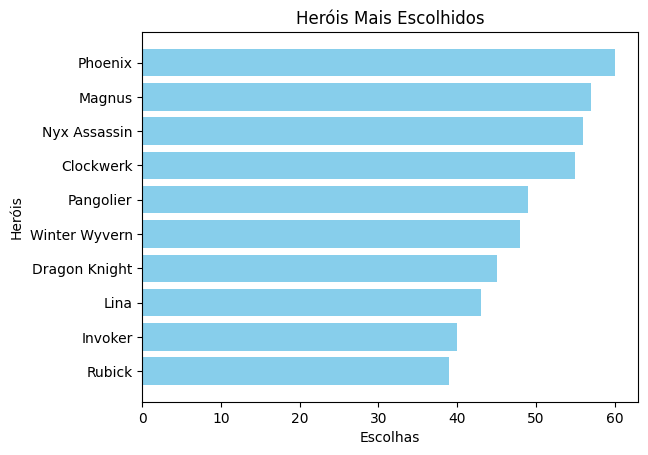

In [37]:
import matplotlib.pyplot as plt

heroes, counts = zip(*hero_counts_named)
plt.barh(heroes, counts, color='skyblue')
plt.xlabel('Escolhas')
plt.ylabel('Heróis')
plt.title('Heróis Mais Escolhidos')
plt.gca().invert_yaxis()
plt.show()


In [56]:
df_cleaned = df.dropna(subset=['Radiant_Heroes', 'Dire_Heroes'])

In [66]:
win_rates_cleaned = {hero: rate for hero, rate in win_rates_named.items() if rate > 0}
win_rates_named = {hero: (rate if not isinstance(rate, float) or not pd.isna(rate) else 0) for hero, rate in win_rates_named.items()}
# Exibir resultados sem 'nan'
print("Taxa de vitória dos heróis:")
for hero, win_rate in sorted(win_rates_named.items(), key=lambda x: x[1], reverse=True):
    if win_rate > 0:
        print(f"{hero}: {win_rate:.2%}")


Taxa de vitória dos heróis:
Undying: 100.00%
Silencer: 85.71%
Enchantress: 80.95%
Keeper of the Light: 80.00%
Skywrath Mage: 80.00%
Sven: 77.78%
Legion Commander: 76.92%
Arc Warden: 75.00%
Venomancer: 75.00%
Tidehunter: 75.00%
Clinkz: 75.00%
Treant Protector: 75.00%
Riki: 75.00%
Grimstroke: 71.43%
Pugna: 69.23%
Phoenix: 66.67%
Oracle: 66.67%
Nature's Prophet: 66.67%
Faceless Void: 66.67%
Death Prophet: 66.67%
Puck: 65.62%
Terrorblade: 64.71%
Techies: 64.29%
Bounty Hunter: 63.64%
Disruptor: 63.64%
Dark Seer: 62.50%
Marci: 61.54%
Gyrocopter: 61.11%
Tiny: 60.87%
Void Spirit: 60.87%
Ursa: 60.00%
Viper: 60.00%
Troll Warlord: 60.00%
Windranger: 60.00%
Snapfire: 60.00%
Underlord: 60.00%
Magnus: 57.89%
Visage: 57.89%
Pangolier: 57.14%
Leshrac: 57.14%
Necrophos: 57.14%
Storm Spirit: 56.00%
Ogre Magi: 55.26%
Night Stalker: 55.00%
Weaver: 55.00%
Drow Ranger: 54.55%
Queen of Pain: 54.55%
Winter Wyvern: 54.17%
Alchemist: 54.05%
Lifestealer: 53.85%
Shadow Demon: 53.57%
Lina: 53.49%
Muerta: 53.33%
Ve

In [68]:
print(df.columns)


Index(['Match_ID', 'Radiant_Heroes', 'Dire_Heroes', 'Radiant_Win'], dtype='object')


In [77]:
from sklearn.preprocessing import MultiLabelBinarizer

# Codificar heróis escolhidos
mlb = MultiLabelBinarizer()
radiant_encoded = mlb.fit_transform(df['Radiant_Heroes'])
dire_encoded = mlb.transform(df['Dire_Heroes'])

# Criar DataFrame com heróis codificados
radiant_df = pd.DataFrame(radiant_encoded, columns=["Radiant_" + str(hero) for hero in mlb.classes_])
dire_df = pd.DataFrame(dire_encoded, columns=["Dire_" + str(hero) for hero in mlb.classes_])

# Combinar com o resultado da partida
model_df = pd.concat([radiant_df, dire_df, df['Radiant_Win']], axis=1)
print(model_df.head())


   Radiant_1  Radiant_2  Radiant_3  Radiant_4  Radiant_5  Radiant_6  \
0          0          0          0          0          0          0   
1          1          0          0          0          0          0   
2          0          0          0          0          0          1   
3          0          0          0          1          0          0   
4          0          0          0          0          0          0   

   Radiant_7  Radiant_8  Radiant_9  Radiant_10  ...  Dire_121  Dire_123  \
0          0          0          0           1  ...         0         0   
1          0          0          0           0  ...         0         0   
2          0          0          0           0  ...         0         0   
3          0          0          0           0  ...         0         0   
4          0          0          0           1  ...         0         0   

   Dire_126  Dire_128  Dire_129  Dire_135  Dire_136  Dire_137  Dire_138  \
0         0         0         0         1      

In [78]:
from sklearn.model_selection import train_test_split

X = final_df.drop('Radiant_Win', axis=1)  # Features (heróis escolhidos)
y = final_df['Radiant_Win']  # Rótulo (se o Radiant venceu)

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Previsões e métricas
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.55      0.67      0.60         9
        True       0.67      0.55      0.60        11

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



In [79]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Previsões e métricas
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.60      0.67      0.63         9
        True       0.70      0.64      0.67        11

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Inicialização do modelo KNN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# Previsões e métricas
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.44      0.78      0.56         9
        True       0.50      0.18      0.27        11

    accuracy                           0.45        20
   macro avg       0.47      0.48      0.41        20
weighted avg       0.47      0.45      0.40        20

